# Data-Centric NLP 대회: 주제 분류 프로젝트

## Load Libraries

In [2]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset

import evaluate
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer

from sklearn.model_selection import train_test_split

## Set Hyperparameters

In [3]:
SEED = 456
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [4]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [5]:
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, '../data')
OUTPUT_DIR = os.path.join(BASE_DIR, '../output')

## Load Tokenizer and Model

In [6]:
model_name = 'klue/bert-base'
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=7).to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained(model_name, max_length=64)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initial

## Define Dataset

In [7]:
data = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
dataset_train, dataset_valid = train_test_split(data, test_size=0.3, stratify=data['target'],random_state=SEED)

In [8]:
class BERTDataset(Dataset):
    def __init__(self, data, tokenizer):
        input_texts = data['text']
        targets = data['target']
        self.inputs = []
        self.labels = []
        
        for text, label in zip(input_texts, targets):
            tokenized_input = tokenizer(text, padding='max_length', truncation=True, return_tensors='pt')
            self.inputs.append(tokenized_input)
            self.labels.append(torch.tensor(label))
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.inputs[idx]['input_ids'].squeeze(0),  
            'attention_mask': self.inputs[idx]['attention_mask'].squeeze(0),
            'labels': self.labels[idx].squeeze(0)
        }
    
    def __len__(self):
        return len(self.labels)

In [9]:
data_train = BERTDataset(dataset_train, tokenizer)
data_valid = BERTDataset(dataset_valid, tokenizer)

In [10]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## Define Metric

In [11]:
f1 = evaluate.load('f1')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return f1.compute(predictions=predictions, references=labels, average='macro')

## Train Model

In [12]:
### for wandb setting
#os.environ['WANDB_DISABLED'] = 'true'
import wandb

entity_name = input("input entity name : ")
wandb.init(project='주제 분류 프로젝트', name=entity_name)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: Currently logged in as: catwave (level2-klue-nlp-05). Use `wandb login --relogin` to force relogin


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [13]:
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    do_predict=True,
    logging_strategy='steps',
    evaluation_strategy='steps',
    save_strategy='steps',
    logging_steps=100,
    eval_steps=100,
    save_steps=100,
    save_total_limit=2,
    learning_rate= 2e-05,
    adam_beta1 = 0.9,
    adam_beta2 = 0.999,
    adam_epsilon=1e-08,
    weight_decay=0.01,
    lr_scheduler_type='linear',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    load_best_model_at_end=True,
    metric_for_best_model='eval_f1',
    greater_is_better=True,
    seed=SEED
)

In [14]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data_train,
    eval_dataset=data_valid,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [15]:
trainer.train()

/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 4900
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 308
  Number of trainable parameters = 110622727
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,F1
100,1.065300,0.570838,0.833538
200,0.544900,0.518282,0.845228
300,0.475900,0.511175,0.853581


***** Running Evaluation *****
  Num examples = 2100
  Batch size = 32
Saving model checkpoint to /data/ephemeral/home/level2-nlp-datacentric-nlp-05/code/../output/checkpoint-100
Configuration saved in /data/ephemeral/home/level2-nlp-datacentric-nlp-05/code/../output/checkpoint-100/config.json
Model weights saved in /data/ephemeral/home/level2-nlp-datacentric-nlp-05/code/../output/checkpoint-100/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2100
  Batch size = 32
Saving model checkpoint to /data/ephemeral/home/level2-nlp-datacentric-nlp-05/code/../output/checkpoint-200
Configuration saved in /data/ephemeral/home/level2-nlp-datacentric-nlp-05/code/../output/checkpoint-200/config.json
Model weights saved in /data/ephemeral/home/level2-nlp-datacentric-nlp-05/code/../output/checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2100
  Batch size = 32
Saving model checkpoint to /data/ephemeral/home/level2-nlp-datacentric-nlp-05/code/../output/ch

TrainOutput(global_step=308, training_loss=0.6884691947466367, metrics={'train_runtime': 363.2986, 'train_samples_per_second': 26.975, 'train_steps_per_second': 0.848, 'total_flos': 2578604098560000.0, 'train_loss': 0.6884691947466367, 'epoch': 2.0})

## Evaluate Model

In [16]:
dataset_test = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))

In [17]:
# model.eval()
# preds = []
# for idx, sample in tqdm(dataset_test.iterrows()):
#     inputs = tokenizer(sample['text'], return_tensors="pt").to(DEVICE)
#     with torch.no_grad():
#         logits = model(**inputs).logits
#         pred = torch.argmax(torch.nn.Softmax(dim=1)(logits), dim=1).cpu().numpy()
#         preds.extend(pred)

In [18]:
# dataset_test['target'] = preds
# dataset_test.to_csv(os.path.join(BASE_DIR, 'output.csv'), index=False)

# 사후분석

In [19]:
valid_preds = []
for idx, sample in tqdm(dataset_valid.iterrows()):
    inputs = tokenizer(sample['text'], return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        logits = model(**inputs).logits
        pred = torch.argmax(torch.nn.Softmax(dim=1)(logits), dim=1).cpu().numpy()
        valid_preds.extend(pred)
        
dataset_valid['pred'] = valid_preds
dataset_valid.to_csv(os.path.join(BASE_DIR, 'valid_output.csv'), index=False)


2100it [00:22, 94.48it/s] 


In [20]:
dataset_valid = dataset_valid[['text', 'target', 'pred']]
dataset_valid

,text,target,pred
2602,나태주 너를 먼저 생각한다면 미투 나올 일 없겠죠,2,2
964,손학규 曺 임명은 정권위기로 연결…지명철회 촉구,6,6
2893,北 청년동맹 70돌 행사 연일보도…대북제재 겨냥 체제결속,6,6
3318,가장 순수한 춤…서울국제즉흥춤축제 24일 개막,3,3
3788,카슈끄지 살해 주범 빈살마 놩세자 보좌과 녀전히 실세로 활동,4,4
...,...,...,...
5848,KT파워텔 폴더형 LTE 무전기 라져 F2 출시,0,0
4259,게시판 창의재단고용노동부 강남지청 일·가정 양립 MOU,2,2
5503,카드뉴스 우주의 유리천장을 깬 흑인 여성들,0,4
1745,작년 방한 관광객 12년만에 뒷걸음…메르스 영향,2,3


<Axes: xlabel='target', ylabel='count'>

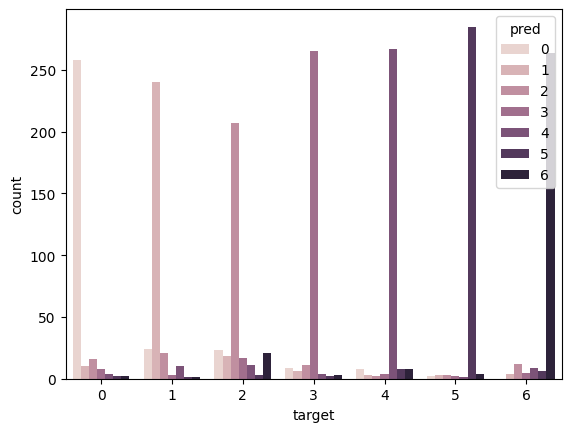

In [21]:
# visualize
import matplotlib.pyplot as plt
import seaborn as sns

# x=target, y=pred
sns.countplot(x='target', hue='pred', data=dataset_valid)

In [22]:
# wrong prediction
wrong_pred = dataset_valid[dataset_valid['target'] != dataset_valid['pred']]
wrong_pred['text']

1209      대통령 퇴진 4개월째 시위 수단서 저항의 상징 여성 눈길
5779     공시가 인상에 경기침체속 임대료도 오르나 촉각…매물 늘 듯
2096    홍세섭 영모도부터 김환기 서예까지…정동1928아트센터 개관전
1236        박근혜 특활비 등 1심 선고 실시간 시청률 6.67％
4163       安 日이 한 입 갖고 두말…위안부합의 당장 무효선언해야
                      ...                
2166     카카오게임즈 블루홀 개발 MMORPG 에어 국내 판권 확보
334                           질의하는 윤한홍 의원
5503              카드뉴스 우주의 유리천장을 깬 흑인 여성들
1745           작년 방한 관광객 12년만에 뒷걸음…메르스 영향
1864      독일 11월 소비자물가 전년보다 1.1% 상승…약세 지속
Name: text, Length: 314, dtype: object